In [117]:
import pandas as pd
import numpy as np
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam

# Questão 1

In [2]:
# Carregando os dados
train_data = pd.read_csv(r"C:\Users\arthu\Downloads\train.csv")
test_data = pd.read_csv(r"C:\Users\arthu\Downloads\test.csv")
titanic_leaked = pd.read_csv(r"C:\Users\arthu\Downloads\titanic.csv")

In [3]:
# concatenar a coluna survived de titanic_leaked em test_data
test_data['Survived'] = titanic_leaked['Survived']

**PassengerId**: É um identificador numérico único para cada passageiro. Normalmente, é apenas uma coluna de índice que não tem relação com a sobrevivência de uma pessoa.

**Survived**: É a variável alvo que estamos tentando prever. É um indicador binário (0 ou 1), onde 1 significa que o passageiro sobreviveu ao naufrágio do Titanic, e 0 significa que não sobreviveu.

**Pclass**: Refere-se à classe de bilhete do passageiro, que é um proxy para o status socioeconômico. Pclass é uma variável categórica com valores 1, 2 ou 3, onde 1 é a primeira classe (mais alta), 2 é a segunda classe, e 3 é a terceira classe (mais baixa).

**Name**: O nome do passageiro. Esta coluna contém os nomes completos, incluindo títulos e às vezes outros detalhes como o nome da esposa ou pais. Esses dados podem ser usados para engenharia de características adicionais, como extrair títulos para modelar o status social ou determinar relações familiares.

**Sex**: O gênero do passageiro, normalmente listado como 'male' (masculino) ou 'female' (feminino). Esta é uma característica categórica importante, pois havia uma política de "mulheres e crianças primeiro" para os botes salva-vidas.

**Age**: Idade do passageiro. Pode ser um valor inteiro ou fracionário. A idade é uma variável contínua e pode precisar de tratamento para valores faltantes, pois nem todas as idades são conhecidas.

**SibSp**: Esta coluna representa o número de irmãos/cônjuges a bordo. SibSp é a abreviação de "Siblings and Spouse". O alto número nesta coluna pode indicar que o passageiro estava viajando com a família.

**Parch**: Similar ao SibSp, esta coluna representa o número de pais/filhos a bordo. Parch é a abreviação de "Parents and Children". Valores altos podem indicar famílias viajando juntas.

**Fare**: Tarifa paga pelo passageiro. Este é um valor contínuo que varia dependendo da classe de cabine e outras possíveis fatores como promoções, último minuto de compra, ou acompanhamento de crianças. Pode estar relacionado ao Pclass, mas não é idêntico, pois passageiros na mesma classe podem ter pago tarifas diferentes.

**Embarked**: O porto no qual o passageiro embarcou no Titanic. Existem três valores possíveis: 'C' para Cherbourg, 'Q' para Queenstown (hoje conhecida como Cobh), e 'S' para Southampton.

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Estatísticas descritivas
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
# Verificar valores faltantes
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Tratamento de Dados

In [7]:
# Descartando características não necessárias
train_data.drop(['Ticket' ,'PassengerId'], axis=1, inplace=True)
test_data.drop(['Ticket','PassengerId'], axis=1, inplace=True)

In [8]:
# Usando expressões regulares para extrair o título do nome
train_data['Title'] = train_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
test_data['Title'] = test_data['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Substituir títulos raros por um termo mais comum ou por 'Outros'
title_mapping = {"Mlle": "Miss", "Mme": "Mrs", "Ms": "Miss", "Dr": "Rare", "Rev": "Rare", "Col": "Rare", "Major": "Rare", "Sir": "Rare", "Lady": "Rare", "Capt": "Rare", "Countess": "Rare", "Jonkheer": "Rare"}

train_data['Title'] = train_data['Title'].replace(title_mapping)
test_data['Title'] = test_data['Title'].replace(title_mapping)

# One-hot encoding dos títulos
titles_dummies = pd.get_dummies(train_data['Title'], prefix='Title')
train_data = pd.concat([train_data, titles_dummies], axis=1)
test_data = pd.concat([test_data, pd.get_dummies(test_data['Title'], prefix='Title')], axis=1)

In [9]:
# Preenchendo valores faltantes
train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
test_data['Age'].fillna(test_data['Age'].median(), inplace=True)

# escala logarítmica de Age
train_data['Age_log'] = np.log1p(train_data['Age'])
test_data['Age_log'] = np.log1p(test_data['Age'])

In [10]:
# Codificando variáveis categóricas
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female':1 })

train_data['Sex_Age'] = train_data['Sex'] * train_data['Age']
train_data['Sex_Fare'] = train_data['Sex'] * train_data['Fare']
test_data['Sex_Age'] = test_data['Sex'] * test_data['Age']
test_data['Sex_Fare'] = test_data['Sex'] * test_data['Fare']

train_data['Female_Age_Under_18'] = ((train_data['Sex'] == 1) & (train_data['Age'] < 18)).astype(int)
train_data['Male_Age_Over_50'] = ((train_data['Sex'] == 0) & (train_data['Age'] > 50)).astype(int)
test_data['Female_Age_Under_18'] = ((test_data['Sex'] == 1) & (test_data['Age'] < 18)).astype(int)
test_data['Male_Age_Over_50'] = ((test_data['Sex'] == 0) & (test_data['Age'] > 50)).astype(int)

In [11]:
# Adicionar 1 para evitar log(0) que é indefinido
train_data['Fare'] = np.log(train_data['Fare'] + 1)
test_data['Fare'] = np.log(test_data['Fare'] + 1)

# Criando uma nova coluna para 'Fare' por 'Pclass'
train_data['FarePclass'] = train_data['Fare'] * train_data['Pclass']
test_data['FarePclass'] = test_data['Fare'] * test_data['Pclass']

# Criando uma nova coluna para 'Fare' por 'Age'
train_data['FareAge'] = train_data['Fare'] * train_data['Age']
test_data['FareAge'] = test_data['Fare'] * test_data['Age']

# Criando uma nova coluna para 'Fare' por 'SibSp' (número de irmãos/cônjuges a bordo)
train_data['FareSibSp'] = train_data['Fare'] * train_data['SibSp']
test_data['FareSibSp'] = test_data['Fare'] * test_data['SibSp']

# Criando uma nova coluna para 'Fare' por 'Parch' (número de pais/filhos a bordo)
train_data['FareParch'] = train_data['Fare'] * train_data['Parch']
test_data['FareParch'] = test_data['Fare'] * test_data['Parch']

# Criando uma nova coluna para 'Fare' por pessoa (dividindo pela soma de 'SibSp', 'Parch' + 1)
train_data['FarePerPerson'] = train_data['Fare'] / (train_data['SibSp'] + train_data['Parch'] + 1)
test_data['FarePerPerson'] = test_data['Fare'] / (test_data['SibSp'] + test_data['Parch'] + 1)

# Agora, vamos criar uma coluna que combina 'FarePerPerson' e 'Age'
train_data['FarePerPersonAge'] = train_data['FarePerPerson'] * train_data['Age']
test_data['FarePerPersonAge'] = test_data['FarePerPerson'] * test_data['Age']

In [12]:
train_data['CabinKnown'] = train_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)
test_data['CabinKnown'] = test_data['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# Extrair o deck das cabines
train_data['Deck'] = train_data['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'U')  # 'U' para desconhecido
test_data['Deck'] = test_data['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'U')

# Contar o número de cabines
train_data['NumCabins'] = train_data['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)
test_data['NumCabins'] = test_data['Cabin'].apply(lambda x: len(x.split()) if pd.notna(x) else 0)

# tratar decks como categorias numéricas
decks = train_data['Deck'].unique().tolist()
deck_mapping = {deck: idx for idx, deck in enumerate(decks)}
train_data['Deck'] = train_data['Deck'].map(deck_mapping)
test_data['Deck'] = test_data['Deck'].map(deck_mapping)

# Remove cabin
train_data.drop('Cabin', axis=1, inplace=True)
test_data.drop('Cabin', axis=1, inplace=True)

In [13]:
# Converter 'Embarked' para numérico S = 0, C = 1, Q = 2
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_data['Embarked'] = test_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

In [14]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)

train_data['WomanOrChild'] = ((train_data['Sex'] == 1) | (train_data['Age'] < 18)).astype(int)
test_data['WomanOrChild'] = ((test_data['Sex'] == 1) | (test_data['Age'] < 18)).astype(int)

train_data['Age*Class'] = train_data['Age'] * train_data['Pclass']
train_data['Age*IsAlone'] = train_data['Age'] * train_data['IsAlone']
test_data['Age*Class'] = test_data['Age'] * test_data['Pclass']
test_data['Age*IsAlone'] = test_data['Age'] * test_data['IsAlone']

# Elevando 'Age' e 'Pclass' ao quadrado
train_data['Age^2'] = train_data['Age'] ** 2
train_data['Pclass^2'] = train_data['Pclass'] ** 2
test_data['Age^2'] = test_data['Age'] ** 2
test_data['Pclass^2'] = test_data['Pclass'] ** 2

# Criando interações entre 'Age' e 'Pclass'
train_data['Age*Pclass'] = train_data['Age'] * train_data['Pclass']
train_data['Age^2*Pclass'] = train_data['Age^2'] * train_data['Pclass']
train_data['Age*Pclass^2'] = train_data['Age'] * train_data['Pclass^2']
test_data['Age*Pclass'] = test_data['Age'] * test_data['Pclass']
test_data['Age^2*Pclass'] = test_data['Age^2'] * test_data['Pclass']
test_data['Age*Pclass^2'] = test_data['Age'] * test_data['Pclass^2']

# Elevando 'Fare' e 'FamilySize' ao quadrado
train_data['Fare^2'] = train_data['Fare'] ** 2
train_data['FamilySize^2'] = train_data['FamilySize'] ** 2
test_data['Fare^2'] = test_data['Fare'] ** 2
test_data['FamilySize^2'] = test_data['FamilySize'] ** 2

# Criando interações entre 'Fare' e 'FamilySize'
train_data['Fare*FamilySize'] = train_data['Fare'] * train_data['FamilySize']
train_data['Fare^2*FamilySize'] = train_data['Fare^2'] * train_data['FamilySize']
train_data['Fare*FamilySize^2'] = train_data['Fare'] * train_data['FamilySize^2']
test_data['Fare*FamilySize'] = test_data['Fare'] * test_data['FamilySize']
test_data['Fare^2*FamilySize'] = test_data['Fare^2'] * test_data['FamilySize']
test_data['Fare*FamilySize^2'] = test_data['Fare'] * test_data['FamilySize^2']

# Outras interações polinomiais
train_data['Age*IsAlone'] = train_data['Age'] * train_data['IsAlone']
train_data['FarePerPerson^2'] = train_data['FarePerPerson'] ** 2
train_data['FareAge*Pclass'] = train_data['FareAge'] * train_data['Pclass']
test_data['Age*IsAlone'] = test_data['Age'] * test_data['IsAlone']
test_data['FarePerPerson^2'] = test_data['FarePerPerson'] ** 2
test_data['FareAge*Pclass'] = test_data['FareAge'] * test_data['Pclass']

In [15]:
train_data.drop(['Name','Title','Sex_Age','Age^2','Age^2*Pclass','Sex_Fare','FareAge*Pclass','Age','Embarked','Fare^2','Fare*FamilySize^2',
                 'FarePerPersonAge','Age*Pclass^2','FamilySize^2','FarePerPerson^2','Title_Miss','FareParch'], axis=1, inplace=True)

test_data.drop(['Name','Title','Sex_Age','Age^2','Age^2*Pclass','Sex_Fare','FareAge*Pclass','Age','Embarked','Fare^2','Fare*FamilySize^2',
                 'FarePerPersonAge','Age*Pclass^2','FamilySize^2','FarePerPerson^2','Title_Miss','FareParch'], axis=1, inplace=True)

In [16]:
test_data

,Pclass,Sex,SibSp,Parch,Fare,Survived,Title_Dona,Title_Master,Title_Mr,Title_Mrs,...,NumCabins,FamilySize,IsAlone,WomanOrChild,Age*Class,Age*IsAlone,Pclass^2,Age*Pclass,Fare*FamilySize,Fare^2*FamilySize
0,3,0,0,0,2.178064,0,0,0,1,0,...,0,1,1,0,103.5,34.5,9,103.5,2.178064,4.743965
1,3,1,1,0,2.079442,1,0,0,0,1,...,0,2,0,1,141.0,0.0,9,141.0,4.158883,8.648154
2,2,0,0,0,2.369075,0,0,0,1,0,...,0,1,1,0,124.0,62.0,4,124.0,2.369075,5.612516
3,3,0,0,0,2.268252,0,0,0,1,0,...,0,1,1,0,81.0,27.0,9,81.0,2.268252,5.144969
4,3,1,1,1,2.586824,1,0,0,0,1,...,0,3,0,1,66.0,0.0,9,66.0,7.760471,20.074971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,2.202765,0,0,0,1,0,...,0,1,1,0,81.0,27.0,9,81.0,2.202765,4.852173
414,1,1,0,0,4.699571,1,1,0,0,0,...,1,1,1,1,39.0,39.0,1,39.0,4.699571,22.085966
415,3,0,0,0,2.110213,0,0,0,1,0,...,0,1,1,0,115.5,38.5,9,115.5,2.110213,4.453000
416,3,0,0,0,2.202765,0,0,0,1,0,...,0,1,1,0,81.0,27.0,9,81.0,2.202765,4.852173


In [17]:
train_data

,Survived,Pclass,Sex,SibSp,Parch,Fare,Title_Don,Title_Master,Title_Mr,Title_Mrs,...,NumCabins,FamilySize,IsAlone,WomanOrChild,Age*Class,Age*IsAlone,Pclass^2,Age*Pclass,Fare*FamilySize,Fare^2*FamilySize
0,0,3,0,1,0,2.110213,0,0,1,0,...,0,2,0,0,66.0,0.0,9,66.0,4.220426,8.906000
1,1,1,1,1,0,4.280593,0,0,0,1,...,1,2,0,1,38.0,0.0,1,38.0,8.561186,36.646955
2,1,3,1,0,0,2.188856,0,0,0,0,...,0,1,1,1,78.0,26.0,9,78.0,2.188856,4.791092
3,1,1,1,1,0,3.990834,0,0,0,1,...,1,2,0,1,35.0,0.0,1,35.0,7.981668,31.853515
4,0,3,0,0,0,2.202765,0,0,1,0,...,0,1,1,0,105.0,35.0,9,105.0,2.202765,4.852173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,0,2.639057,0,0,0,0,...,0,1,1,0,54.0,27.0,4,54.0,2.639057,6.964624
887,1,1,1,0,0,3.433987,0,0,0,0,...,1,1,1,1,19.0,19.0,1,19.0,3.433987,11.792268
888,0,3,1,1,2,3.196630,0,0,0,0,...,0,4,0,1,84.0,0.0,9,84.0,12.786521,40.873779
889,1,1,0,0,0,3.433987,0,0,1,0,...,1,1,1,0,26.0,26.0,1,26.0,3.433987,11.792268


In [18]:
# Remover Nan
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

In [19]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_test = test_data.drop('Survived', axis=1)
y_test = test_data['Survived']

In [21]:
features = X.columns

In [22]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().reshape(-1, 1)
X_val = X_val.to_numpy()
y_val = y_val.to_numpy().reshape(-1, 1)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().reshape(-1, 1)

In [23]:
X_train = X_train.T
y_train = y_train.T
X_val = X_val.T
y_val = y_val.T
X_test = X_test.T
y_test = y_test.T

In [24]:
X_train.shape

(29, 712)

In [25]:
y_train.shape

(1, 712)

## Rede neural

### Inicialização de parâmetros

**np.random.seed(3)**: Esta linha é usada para garantir que a função gere os mesmos números aleatórios cada vez que é executada. Isso é útil para a reprodutibilidade dos resultados. O número `3` é apenas um número arbitrário que serve como semente (seed).

**parameters = {}**: Cria um dicionário vazio chamado `parameters`. Este dicionário será usado para armazenar os pesos e os vieses da rede neural.

**L = len(layer_dims)**: Aqui, `L` é o número total de camadas na rede, incluindo a camada de entrada e a camada de saída. O parâmetro `layer_dims` é uma lista que contém o número de neurônios em cada camada da rede.

**for l in range(1, L)**: Este é um loop que itera sobre todas as camadas da rede (exceto a camada de entrada, daí começamos de `1` e não de `0`). Para cada camada, ele inicializa os parâmetros `W` (pesos) e `b` (vieses).

**parameters['W' + str(l)]**: Para cada camada `l`, inicializa uma matriz de pesos `W`. Os pesos são inicializados aleatoriamente com uma distribuição normal (gaussiana). A linha `np.random.randn(layer_dims[l], layer_dims[l-1])` cria uma matriz com dimensões especificadas pela camada atual `l` e pela camada anterior `l-1`. O fator `0.01` é usado para manter os pesos pequenos, ajudando a evitar problemas com gradientes muito grandes no início do treinamento.

**parameters['b' + str(l)]**: Similarmente, para cada camada `l`, inicializa um vetor de vieses `b`. Os vieses são inicializados com zeros. A expressão `np.zeros((layer_dims[l], 1))` cria um vetor coluna com `layer_dims[l]` elementos, todos iguais a zero.

In [66]:
def initialize_parameters_deep(layer_dims):
   
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)  

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

### Combinação linear

**A**: A saída(ativação) da camada anterior (ou os dados de entrada para a primeira camada oculta). É uma matriz onde cada coluna representa um exemplo de treinamento e cada linha um neurônio da camada anterior.

**W**: A matriz de pesos associada à camada atual. As dimensões desta matriz dependem do número de neurônios na camada atual (definido pelo número de linhas) e no número de neurônios na camada anterior (definido pelo número de colunas).

**b**: O vetor de viés associado à camada atual. Sua dimensão é igual ao número de neurônios na camada atual e é adicionado a cada unidade de saída antes da aplicação da função de ativação.

A operação realizada pela função é descrita pela seguinte equação matemática:

$$ Z = W \cdot A + b $$

Onde:
- **Z**: O resultado da operação linear, que é a entrada para a função de ativação da camada atual. Este é um vetor ou matriz que representa a combinação linear das entradas com os pesos e os viéses.
- **cache**: Um tuplo que armazena os valores de A, W, e b. Esses valores são armazenados para serem utilizados posteriormente durante a retropropagação (backpropagation), pois serão necessários para calcular os gradientes dos pesos e viéses.


In [67]:
def linear_forward(A, W, b):
  
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

### Funções de ativação

In [68]:
# Implementa a função de ativação Sigmoid
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    return A, cache

# Implementa a função de ativação ReLU
def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache


# Implementa a função de ativação Softmax
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    A = expZ / (np.sum(expZ, axis=0, keepdims=True) + 1e-8)
    cache = Z
    return A, cache

# Implementa a função de ativação Linear
def linear_activation(Z):
   
    A = Z
    cache = Z
    return A, cache

### Computação das ativações

- **A_prev**: A ativação da camada anterior ou os dados de entrada para a primeira camada oculta.
- **W**: A matriz de pesos associada à camada atual.
- **b**: O vetor de viés associado à camada atual.
- **activation**: Uma string que especifica a função de ativação a ser utilizada ("sigmoid" ou "relu").
- **keep_prob**: A probabilidade de manter um neurônio ativo durante dropout; um valor de 1 significa que o dropout não é aplicado, enquanto valores menores que 1 ativam o dropout.

Etapas realizadas pela função:
1. **Operação Linear**: Primeiro, a função realiza a operação linear usando os parâmetros `A_prev`, `W`, e `b` através da chamada à função `linear_forward`, resultando em `Z` e armazenando os valores intermediários em `linear_cache`.

2. **Aplicação da Função de Ativação**: Dependendo do valor do parâmetro `activation`, a função `sigmoid` ou `relu` é aplicada a `Z`. O resultado dessa operação é armazenado em `A` (ativação da camada atual), e os valores intermediários são armazenados em `activation_cache`.

3. **Aplicação de Dropout** (se `keep_prob` < 1): Uma matriz `D` é gerada com dimensões iguais a `A`, onde cada elemento é selecionado aleatoriamente para ser 0 (neurônio desativado) ou 1 (neurônio ativado) com base em `keep_prob`. `A` é então multiplicado por `D` para desativar aleatoriamente alguns neurônios e escalado por `keep_prob` para manter a expectativa do valor de ativação inalterada.

4. **Retorno dos Resultados**: A função retorna `A`, a ativação da camada atual após aplicação da função de ativação e do dropout (se aplicável), juntamente com `cache`, que contém `linear_cache`, `activation_cache`, e `D` (o último é `None` se `keep_prob` = 1, ou seja, sem dropout).

In [69]:
def linear_activation_forward(A_prev, W, b, activation, keep_prob=1):
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A, activation_cache = sigmoid(Z)
    elif activation == "relu":
        A, activation_cache = relu(Z)
    elif activation == "softmax":
        A, activation_cache = softmax(Z)

    D = None
    if keep_prob < 1:
        D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
        A = A * D
        A = A / keep_prob

    cache = (linear_cache, activation_cache, D)

    return A, cache

### Foward propagation

- **X**: A matriz de entrada para a rede, onde cada coluna representa um exemplo de treinamento.
- **parameters**: Um dicionário contendo os parâmetros "W" e "b" para cada camada da rede.
- **hidden_activation**: A função de ativação a ser usada nas camadas ocultas. Geralmente, "relu" é usada por sua eficácia em evitar o problema do gradiente desaparecendo em redes profundas.
- **output_activation**: A função de ativação a ser usada na camada de saída, escolhida com base no tipo de problema (e.g., "sigmoid" para classificação binária, "softmax" para classificação multiclasse).
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout nas camadas ocultas. Um valor de 1 significa que o dropout não é aplicado.

Processo da função:
1. **Inicializações**: Uma lista `caches` é inicializada para armazenar caches de cada camada, e `A` é inicialmente definido como `X` (a entrada para a primeira camada).
2. **Iteração pelas Camadas Ocultas**: Para cada camada oculta (`for l in range(1, L)`), a função `linear_activation_forward` é chamada com a ativação da camada anterior (`A_prev`), os parâmetros da camada atual (`W[l]`, `b[l]`), a função de ativação `hidden_activation`, e `keep_prob`. O resultado (ativação da camada atual) é armazenado em `A`, e o cache correspondente é adicionado à lista `caches`.
3. **Camada de Saída**: Após processar todas as camadas ocultas, a função `linear_activation_forward` é chamada mais uma vez para a camada de saída, usando a ativação da última camada oculta como entrada e a função de ativação `output_activation`. Nesta etapa, `keep_prob` é definido como 1 para desabilitar o dropout.
4. **Retorno dos Resultados**: A função retorna `AL` (a ativação da última camada, que representa as previsões da rede) e `caches` (contendo todos os caches das camadas para uso na retropropagação).


In [70]:
def L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=1):
    caches = []
    A = X
    L = len(parameters) // 2
    
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(
            A_prev, 
            parameters['W' + str(l)], 
            parameters['b' + str(l)], 
            activation=hidden_activation, 
            keep_prob=keep_prob
        )
        caches.append(cache)
    
    AL, cache = linear_activation_forward(
        A, 
        parameters['W' + str(L)], 
        parameters['b' + str(L)], 
        activation=output_activation, 
        keep_prob=1
    )
    caches.append(cache)
    
    return AL, caches

### Função de custo

- **AL**: A ativação da última camada da rede neural, que contém as previsões do modelo.
- **Y**: Os rótulos verdadeiros dos dados de treinamento.
- **parameters**: Um dicionário contendo os parâmetros "W" e "b" de cada camada da rede.
- **lambd**: O hiperparâmetro de regularização L2. Um valor de `0` significa que não há regularização.
- **problema**: Uma string que indica o tipo de problema que a rede está tentando resolver: 'regressao', 'classificacao_binaria', ou 'classificacao_multiclasse'.

Processo da função:
1. **Cálculo do Custo Base**:
   - Para **classificação binária**, é calculada a entropia cruzada binária entre as previsões (`AL`) e os rótulos verdadeiros (`Y`), adicionando `epsilon` para evitar o logaritmo de zero.
   - Para **regressão**, é usado o erro quadrático médio entre `AL` e `Y`.
   - Para **classificação multiclasse**, é calculada a entropia cruzada, adequada para problemas com mais de duas classes.

2. **Cálculo do Custo de Regularização L2**:
   - É calculada a soma dos quadrados de todos os pesos (`W`) da rede, multiplicada pelo hiperparâmetro de regularização `lambd` e dividida por `2*m` (onde `m` é o número de exemplos de treinamento). Esse termo adiciona um custo proporcional à magnitude dos pesos, incentivando o modelo a manter os pesos pequenos.

3. **Combinação dos Custos**:
   - O custo total é a soma do custo base (entropia cruzada ou erro quadrático médio) e o custo de regularização L2. Esse custo total é usado para avaliar o quão bem o modelo está se ajustando aos dados enquanto mantém os pesos sob controle para evitar o overfitting.


In [71]:
def compute_cost(AL, Y, parameters, lambd=0, problema='regressao'):
   
    m = Y.shape[1]
    cross_entropy_cost = 0
    if problema == 'classificacao_binaria':
        cross_entropy_cost = -(1./m) * (np.dot(Y, np.log(AL + 1e-8).T) + np.dot(1-Y, np.log(1-AL + 1e-8).T))
    elif problema == 'regressao':
        cross_entropy_cost = (1./m) * np.sum(np.square(AL - Y))
    elif problema == 'classificacao_multiclasse':
        cross_entropy_cost = -(1./m) * np.sum(Y * np.log(AL + 1e-8))
    
    cross_entropy_cost = np.squeeze(cross_entropy_cost)  # Garante que o custo seja um escalar.

    # Calcula o custo de regularização L2
    L = len(parameters) // 2  # Número de camadas na rede
    L2_regularization_cost = 0

    for l in range(1, L + 1):
        L2_regularization_cost += np.sum(np.square(parameters["W" + str(l)]))
    
    L2_regularization_cost = (lambd / (2 * m)) * L2_regularization_cost

    # Soma o custo de entropia cruzada (ou erro quadrático médio) e o custo de regularização
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

### Computção dos gradientes

- **dZ**: O gradiente do custo em relação à saída linear (Z) da camada atual.
- **cache**: Uma tupla contendo `A_prev` (as ativações da camada anterior), `W` (os pesos da camada atual), e `b` (o viés da camada atual). Estes valores foram armazenados durante a propagação para frente para serem utilizados na retropropagação.
- **lambd**: O hiperparâmetro de regularização L2, que adiciona uma penalidade aos pesos para evitar overfitting.

Processo da função:
1. **Recuperação do cache**: Extrai `A_prev`, `W`, e `b` do cache para utilizá-los no cálculo dos gradientes.
   
2. **Cálculo do gradiente dos pesos (dW)**:
   - O gradiente dos pesos é calculado como a média do produto dot entre `dZ` e a transposta de `A_prev`. Essa operação reflete como o custo muda com relação a uma mudança nos pesos.
   - A regularização L2 é aplicada ao gradiente dos pesos, adicionando `(lambd/m) * W` ao gradiente. Isso penaliza pesos grandes, contribuindo para a prevenção do overfitting.
   
3. **Cálculo do gradiente do viés (db)**:
   - O gradiente do viés é calculado como a média da soma de `dZ` ao longo de suas colunas (exemplos de treinamento). Isso indica como o custo muda com uma mudança no viés.
   
4. **Cálculo do gradiente em relação à ativação da camada anterior (dA_prev)**:
   - O gradiente em relação à ativação da camada anterior é obtido pelo produto dot entre a transposta dos pesos (`W.T`) e `dZ`. Isso reflete como o custo muda com relação às ativações da camada anterior, permitindo que a retropropagação continue para a próxima camada anterior no processo de backpropagation.


In [72]:
def linear_backward(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T) + (lambd/m) * W 
    db = (1/m) * np.sum(dZ, axis=1, keepdims=True) 
    dA_prev = np.dot(W.T, dZ) 

    return dA_prev, dW, db

### Derivadas das funções de ativação

In [73]:
def sigmoid_backward(dA, cache):
    
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s) 
    return dZ

def relu_backward(dA, cache):
    
    Z = cache
    dZ = np.array(dA, copy=True) 
    dZ[Z <= 0] = 0 
    return dZ

def softmax_backward(dA, cache):
   
    dZ = dA * (1 - dA) 
    return dZ

### Computação dos gradientes das funções de ativação

- **dA**: O gradiente do custo em relação à ativação da camada atual.
- **cache**: Contém três componentes principais:
  - **linear_cache**: Armazena os valores de `A_prev`, `W`, e `b` da propagação para frente.
  - **activation_cache**: Guarda os valores de `Z`, a saída linear antes da aplicação da função de ativação.
  - **D**: Matriz de dropout que indica quais neurônios foram mantidos durante a propagação para frente.
- **activation**: Indica a função de ativação usada na camada ("relu" ou "sigmoid").
- **lambd**: O hiperparâmetro de regularização L2.
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout.

Processo da função:

1. **Aplicação do Dropout**:
   - Se `keep_prob` é menor que 1, o gradiente `dA` é ajustado para refletir apenas os neurônios ativos durante a propagação para frente. Isso é feito multiplicando `dA` pela matriz `D` e dividindo pelo `keep_prob`. Este passo assegura que apenas os gradientes dos neurônios ativos são passados para trás.

2. **Cálculo do Gradiente da Função de Ativação (dZ)**:
   - Dependendo da função de ativação usada, calcula-se o gradiente `dZ` da função de ativação com relação a `Z` (armazenado em `activation_cache`). Para "relu", utiliza-se `relu_backward`, e para "sigmoid", `sigmoid_backward`.

3. **Cálculo dos Gradientes Lineares (dA_prev, dW, db)**:
   - Com o `dZ` obtido, chama-se a função `linear_backward` para calcular os gradientes em relação à ativação da camada anterior (`dA_prev`), os pesos (`dW`), e os vieses (`db`). A regularização L2 é aplicada nesse passo para os pesos.


In [74]:
def linear_activation_backward(dA, cache, activation, lambd, keep_prob):
    linear_cache, activation_cache, D = cache

    if keep_prob < 1:
        dA = dA * D
        dA = dA / keep_prob

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
    elif activation == "softmax":
        # Para softmax com perda de entropia cruzada, a derivada da perda em relação a Z é simplificada.
        dZ = dA  # Aqui activation_cache idealmente deve ser dA diretamente, que é (A - Y).

    dA_prev, dW, db = linear_backward(dZ, linear_cache, lambd)

    return dA_prev, dW, db

### Backpropagation

- **AL**: A última saída de ativação da propagação para frente, equivalente às previsões do modelo.
- **Y**: Os rótulos verdadeiros do conjunto de dados.
- **caches**: Uma lista que contém os caches de cada camada, armazenados durante a propagação para frente. Cada cache contém informações necessárias para a retropropagação naquela camada específica.
- **lambd**: O hiperparâmetro de regularização L2.
- **keep_prob**: A probabilidade de manter um neurônio ativo durante o dropout.
- **hidden_activation**: A função de ativação usada nas camadas ocultas ("relu", por exemplo).
- **output_activation**: A função de ativação usada na camada de saída ("sigmoid", por exemplo, para classificação binária).
- **problema**: O tipo de problema sendo resolvido ("classificacao_binaria" nesse caso).

Processo da função:

1. **Inicialização**:
   - Prepara o dicionário `grads` para armazenar os gradientes calculados.
   - Redimensiona `Y` para que tenha o mesmo formato que `AL`.
   - Se estiver resolvendo uma classificação binária, ajusta `AL` para evitar divisão por zero durante o cálculo do gradiente `dAL`.

2. **Gradientes da Camada de Saída**:
   - Calcula o gradiente da ativação da última camada (`dAL`) com base na diferença entre as previsões (`AL`) e os rótulos verdadeiros (`Y`).
   - Usa `linear_activation_backward` para calcular os gradientes da última camada, considerando a função de ativação de saída e sem aplicar dropout (`keep_prob=1`).

3. **Retropropagação pelas Camadas Ocultas**:
   - Itera pelas camadas ocultas em ordem reversa, usando o gradiente da ativação da camada seguinte (`dA_prev_temp`) e o cache da camada atual para calcular os gradientes com `linear_activation_backward`.
   - Neste processo, aplica-se o dropout conforme especificado por `keep_prob` e a regularização L2 conforme `lambd`.

4. **Armazenamento dos Gradientes**:
   - Os gradientes calculados (`dA_prev`, `dW`, `db`) para cada camada são armazenados no dicionário `grads`.


In [75]:
def L_model_backward(AL, Y, caches, lambd, keep_prob, hidden_activation='relu', output_activation='sigmoid', problema='classificacao_binaria'):
    grads = {}
    L = len(caches)
    Y = Y.reshape(AL.shape)
    
    if problema == 'classificacao_binaria':   
        epsilon = 1e-8
        AL = np.clip(AL, epsilon, 1-epsilon)
        dAL = -(np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    elif problema == 'regressao':
        dAL = 2 * (AL - Y)
    elif problema == 'classificacao_multiclasse':
        dAL = AL - Y
    
    current_cache = caches[L-1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
        dAL, 
        current_cache, 
        output_activation, 
        lambd, 
        keep_prob=1
    )
    grads["dA" + str(L-1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(
            grads["dA" + str(l+1)], 
            current_cache, 
            hidden_activation, 
            lambd, 
            keep_prob
        )
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Atualização dos parâmetros

**Parâmetros da função:**

- **params**: Dicionário contendo os parâmetros atuais da rede, ou seja, os pesos (`W`) e os vieses (`b`) de cada camada.
- **grads**: Dicionário contendo os gradientes dos parâmetros calculados pela retropropagação. Inclui os gradientes dos pesos (`dW`) e dos vieses (`db`) para cada camada.
- **learning_rate**: Taxa de aprendizado utilizada para ponderar o tamanho do passo na atualização dos parâmetros.

**Processo da função:**

1. **Cópia Profunda dos Parâmetros**: Uma cópia profunda (`deepcopy`) dos parâmetros é criada para evitar alterações diretas no dicionário original durante a atualização. Isso garante que os cálculos sejam realizados com base nos valores originais dos parâmetros no início da iteração.

2. **Atualização dos Parâmetros**:
   - A função itera sobre cada camada da rede (desde a primeira até a última camada, cujo número é determinado por `L`).
   - Para cada camada `l`, os pesos `W[l]` são atualizados subtraindo o produto da taxa de aprendizado (`learning_rate`) pelo gradiente correspondente dos pesos (`dW[l]`). Esse cálculo é realizado para ajustar os pesos na direção que minimiza a função de custo.
   - De maneira similar, os vieses `b[l]` são atualizados subtraindo o produto da taxa de aprendizado pelo gradiente correspondente dos vieses (`db[l]`).

3. **Retorno dos Parâmetros Atualizados**: Após a atualização de todos os parâmetros, o dicionário `parameters` é retornado. Este contém os valores atualizados de pesos e vieses para todas as camadas, que serão utilizados na próxima iteração do processo de treinamento.

In [76]:
def update_parameters(params, grads, learning_rate=0.001):
  
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2  # Número de camadas na rede neural

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

### Inicialização do ADAM

**Detalhes da função:**

- **parameters**: Dicionário contendo os parâmetros da rede neural (`W` e `b` para cada camada). É utilizado para determinar a forma dos vetores de momento que serão inicializados.
- **L**: Calcula o número total de camadas na rede neural pela metade do tamanho do dicionário `parameters`, já que cada camada possui um conjunto de pesos `W` e um conjunto de vieses `b`.
- **v**: Dicionário destinado a armazenar os momentos de primeira ordem (médias móveis dos gradientes) dos parâmetros. Inicializa-se com matrizes de zeros com as mesmas dimensões que os pesos `W` e os vieses `b` de cada camada.
- **s**: Dicionário destinado a armazenar os momentos de segunda ordem (médias móveis do quadrado dos gradientes) dos parâmetros. Da mesma forma que `v`, inicializa-se com matrizes de zeros correspondentes às dimensões de `W` e `b` de cada camada.

**Processo da função:**

1. Itera sobre cada camada `l` da rede neural, começando da primeira camada até a última (`L`).
2. Para cada camada, inicializa-se `v["dW" + str(l)]` e `v["db" + str(l)]` com matrizes de zeros que correspondem às dimensões de `W[l]` e `b[l]`, respectivamente. Essas matrizes armazenarão os momentos de primeira ordem para os gradientes dos pesos e vieses.
3. De forma semelhante, inicializa-se `s["dW" + str(l)]` e `s["db" + str(l)]` com matrizes de zeros para armazenar os momentos de segunda ordem dos gradientes dos pesos e vieses.
4. A função retorna os dicionários `v` e `s`, que serão utilizados nas iterações subsequentes do algoritmo Adam para ajustar adaptativamente as taxas de aprendizado dos parâmetros durante o treinamento.

In [77]:
def initialize_adam(parameters) :
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        v["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
        s["dW" + str(l)] = np.zeros((parameters["W" + str(l)].shape))
        s["db" + str(l)] = np.zeros((parameters["b" + str(l)].shape))
    
    return v, s

### Atualização dos parâmetros com ADAM

**Parâmetros da função:**
- **parameters**: Dicionário contendo os parâmetros atuais do modelo (`W` e `b` para cada camada).
- **grads**: Dicionário contendo os gradientes dos parâmetros (`dW` e `db` para cada camada) obtidos na retropropagação.
- **v**: Dicionário contendo as médias móveis estimadas dos gradientes (momentos de primeira ordem).
- **s**: Dicionário contendo as médias móveis estimadas dos quadrados dos gradientes (momentos de segunda ordem).
- **t**: Número da iteração atual (usado para correção de bias).
- **learning_rate**: Taxa de aprendizado.
- **beta1**: Hiperparâmetro para estimativa do momento de primeira ordem (usualmente próximo a 0.9).
- **beta2**: Hiperparâmetro para estimativa do momento de segunda ordem (usualmente próximo a 0.999).
- **epsilon**: Termo adicionado para melhorar a estabilidade numérica (evitar divisão por zero).

**Funcionamento:**
1. **Atualização dos Momentos (v e s)**: Para cada parâmetro (`W` e `b`), a função atualiza os momentos de primeira e segunda ordem com base nos gradientes atuais. Isto é feito usando uma combinação dos valores anteriores de `v` e `s` e os novos gradientes, ponderada pelos hiperparâmetros `beta1` e `beta2`.
   
2. **Correção de Bias nos Momentos (v_corrected e s_corrected)**: Os momentos corrigidos são calculados dividindo os momentos pelos fatores de correção `(1 - beta1^t)` e `(1 - beta2^t)`, respectivamente. Isto corrige o bias inicial dos momentos, que é mais significativo nas primeiras iterações.

3. **Atualização dos Parâmetros**: Os parâmetros são atualizados subtraindo um valor proporcional ao momento de primeira ordem corrigido (`v_corrected`) e normalizado pelo momento de segunda ordem corrigido (`s_corrected`), ajustado pela raiz quadrada e pelo valor de `epsilon`. A taxa de aprendizado é aplicada a essa quantidade para determinar a magnitude da atualização.

**Retorno:**
- **parameters**: Dicionário contendo os parâmetros atualizados.
- **v**: Dicionário atualizado com os novos momentos de primeira ordem.
- **s**: Dicionário atualizado com os novos momentos de segunda ordem.

In [78]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):

    
    L = len(parameters) // 2                
    v_corrected = {}                      
    s_corrected = {}                         
    
  
    for l in range(1, L + 1):
        
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1 ** t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1 ** t)
       
        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * (grads['dW' + str(l)] ** 2)
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * (grads['db' + str(l)] ** 2)

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2 ** t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2 ** t)

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * (v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon))
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * (v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon))
        

    return parameters, v, s

## Treinamento

In [39]:
# Definindo os valores dos hiperparâmetros para a busca em grade
lambd_values = [0.1, 0.01, 0.001]
keep_prob_values = [0.3, 0.4, 0.5]
learning_rate_values = [0.001, 0.0001, 0.00001]
layer_dims = [X_train.shape[0], 16, y_train.shape[0]]  

# Melhores parâmetros e seu desempenho de validação
best_params = {}
best_validation_accuracy = 0
best_parameters = None  # Aqui é onde vamos armazenar os parâmetros do modelo

# Iterando sobre todas as combinações possíveis
for lambd in lambd_values:
    for keep_prob in keep_prob_values:
        for learning_rate in learning_rate_values:
            # Reinicialize os parâmetros e inicializadores do Adam para cada combinação
            parameters = initialize_parameters_deep(layer_dims)
            v, s = initialize_adam(parameters)
            
            # Reset das listas de custos e acurácias
            costs_train = []
            accuracies_train = []
            costs_val = []
            accuracies_val = []
            
            t = 0  # Inicializador para o Adam
            
            for i in range(10000000):
                t += 1
                
                # Propagação para frente (com dropout aplicado no treinamento)
                AL, caches = L_model_forward(X_train, parameters, hidden_activation='relu', output_activation='sigmoid', keep_prob=keep_prob)
                
                # Propagação pra frente nos dados de validação (sem dropout)
                AL_val, _ = L_model_forward(X_val, parameters, hidden_activation='relu', output_activation='sigmoid')
                
                # Cálculo do custo (com regularização L2)
                cost = compute_cost(AL, y_train, parameters, lambd=lambd, problema='classificacao_binaria')
                costs_train.append(cost)
                
                cost_val = compute_cost(AL_val, y_val, parameters, lambd=lambd, problema='classificacao_binaria')
                costs_val.append(cost_val)
                
                # Cálculo da acurácia
                predictions = AL > 0.5
                accuracy = np.mean(predictions == y_train) * 100
                accuracies_train.append(accuracy)
                
                predictions_val = AL_val > 0.5
                accuracy_val = np.mean(predictions_val == y_val) * 100
                accuracies_val.append(accuracy_val)
                
                # Retropropagação e atualização dos parâmetros
                grads = L_model_backward(AL, y_train, caches, lambd=lambd, keep_prob=keep_prob, hidden_activation='relu', output_activation='sigmoid', problema='classificacao_binaria')
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
                
                # Condição de parada antecipada ou outras condições podem ser inseridas aqui
                if i > 0 and abs(costs_val[-1] - costs_val[-2]) < 0.05:
                    no_improvement_epochs += 1
                else:
                    no_improvement_epochs = 0

                if no_improvement_epochs >= 10000:
                    print(f"Parada antecipada na iteração {i}: a melhoria no custo é menor que {0.03} durante {10000} épocas consecutivas.")
                    break

                
            # Verificando se encontramos uma nova melhor combinação de hiperparâmetros
            if max(accuracies_val) > best_validation_accuracy: # mudar para menor erro e não maior acurácia
                best_validation_accuracy = max(accuracies_val)
                best_params = {'lambd': lambd, 'keep_prob': keep_prob, 'learning_rate': learning_rate}
                best_parameters = parameters.copy()

# Imprime os melhores hiperparâmetros encontrados e sua acurácia de validação
print(f"Melhores hiperparâmetros encontrados: {best_params}")
print(f"Acurácia de validação: {best_validation_accuracy}%")


Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada na iteração 10000: a melhoria no custo é menor que 0.05 durante 10000 épocas consecutivas.
Parada antecipada n

In [40]:
AL, _ = L_model_forward(X_test, best_parameters, hidden_activation='relu', output_activation='sigmoid')
predictions = AL > 0.5
accuracy = np.mean(predictions == y_test) * 100
print(f"Acurácia nos dados de teste: {accuracy:.2f}%")

Acurácia nos dados de teste: 77.46%


### Verificar Features desnecessárias

In [41]:
def predict(X, parameters):
    AL, _ = L_model_forward(X, parameters, hidden_activation='relu', output_activation='sigmoid')
    predictions = AL > 0.5
    return predictions

def compute_accuracy(predictions, y):
    accuracy = np.mean(predictions == y) * 100
    return accuracy

def compute_feature_importance(X_test, y_test, parameters, num_runs=1000):
    np.random.seed(42) 
    baseline_predictions = predict(X_test, parameters)
    baseline_accuracy = compute_accuracy(baseline_predictions, y_test)
    feature_importances = np.zeros((X_test.shape[0], num_runs))

    for run in range(num_runs):
        for i in range(X_test.shape[0]):  # Iterando sobre as features
            X_test_permuted = X_test.copy()
            np.random.shuffle(X_test_permuted[i, :])  # Permutando valores da feature
            permuted_predictions = predict(X_test_permuted, parameters)
            permuted_accuracy = compute_accuracy(permuted_predictions, y_test)
            feature_importances[i, run] = baseline_accuracy - permuted_accuracy

    # Calculando a média da importância por feature ao longo das execuções
    feature_importance_means = np.mean(feature_importances, axis=1)
    return feature_importance_means

# Calculando a importância das features
feature_importance_means = compute_feature_importance(X_test, y_test, best_parameters)

# Exibindo a importância média das features
for i, importance in enumerate(feature_importance_means):
    print(f"Feature {i}: {importance:.2f}% change in accuracy on average")

Feature 0: 0.25% change in accuracy on average
Feature 1: 2.44% change in accuracy on average
Feature 2: 0.38% change in accuracy on average
Feature 3: 0.25% change in accuracy on average
Feature 4: 0.51% change in accuracy on average
Feature 5: 0.00% change in accuracy on average
Feature 6: 0.02% change in accuracy on average
Feature 7: 2.05% change in accuracy on average
Feature 8: 1.22% change in accuracy on average
Feature 9: 0.01% change in accuracy on average
Feature 10: 0.46% change in accuracy on average
Feature 11: 0.11% change in accuracy on average
Feature 12: 0.50% change in accuracy on average
Feature 13: -0.18% change in accuracy on average
Feature 14: 0.85% change in accuracy on average
Feature 15: 1.24% change in accuracy on average
Feature 16: 0.50% change in accuracy on average
Feature 17: -0.24% change in accuracy on average
Feature 18: 0.26% change in accuracy on average
Feature 19: 1.27% change in accuracy on average
Feature 20: 0.21% change in accuracy on average


In [42]:
features[27]

'Fare*FamilySize'

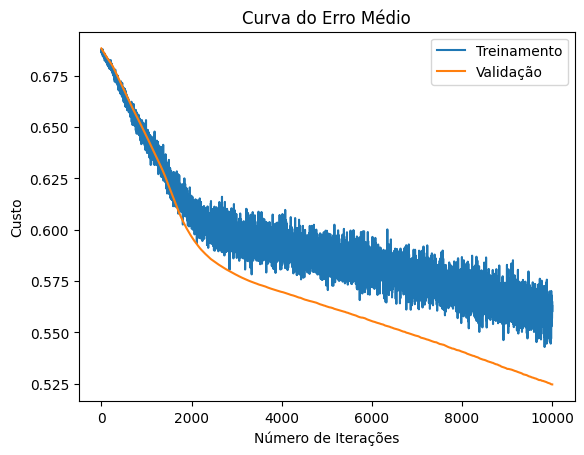

In [43]:
# Número de iterações realizadas (considerando que o loop pode ter parado antes do fim)
iterations = len(costs_train)

# Plotando o custo de treinamento e validação
plt.plot(range(iterations), costs_train, label='Treinamento')
plt.plot(range(iterations), costs_val, label='Validação')

# Adicionando títulos e legendas
plt.title('Curva do Erro Médio')
plt.xlabel('Número de Iterações')
plt.ylabel('Custo')
plt.legend()

# Exibindo o gráfico
plt.show()


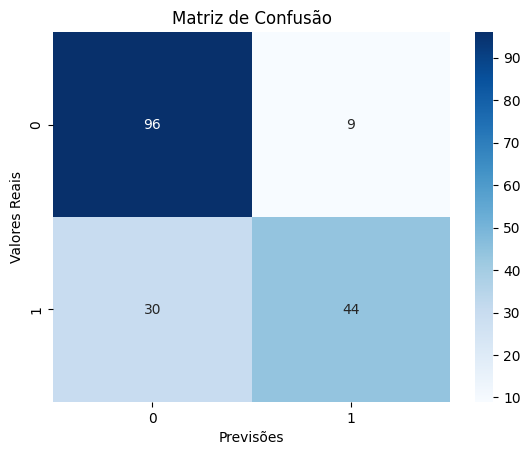

In [44]:
predictions_val_final = predictions_val.astype(int).flatten()
y_val_final = y_val.flatten()

# Gerando a matriz de confusão
cm = confusion_matrix(y_val_final, predictions_val_final)

# Plotando a matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsões')
plt.ylabel('Valores Reais')
plt.title('Matriz de Confusão')
plt.show()

# Questão 2

In [89]:
def read_mnist(images_path, labels_path):
    with open(images_path, 'rb') as f:
        magic, num, rows, cols = np.frombuffer(f.read(16), dtype='>i4')
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)

    with open(labels_path, 'rb') as f:
        magic, num = np.frombuffer(f.read(8), dtype='>i4')
        labels = np.frombuffer(f.read(), dtype=np.uint8)

    return images, labels

# Note: You need to replace the paths with the correct ones for your local file system
train_images_path = r"C:\Users\arthu\Downloads\archive\train-images.idx3-ubyte"
train_labels_path = r"C:\Users\arthu\Downloads\archive\train-labels.idx1-ubyte"

train_images, train_labels = read_mnist(train_images_path, train_labels_path)

print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [90]:
train_images_reshaped = train_images.reshape(train_images.shape[0], 28, 28, 1)

In [91]:
def convert_to_one_hot(y, num_classes):
   
    m = y.shape[0]
    one_hot = np.zeros((m, num_classes))
    one_hot[np.arange(m), y] = 1
    return one_hot

# Número de classes para o MNIST é 10 (dígitos de 0 a 9)
num_classes = 10
train_labels_one_hot = convert_to_one_hot(train_labels, num_classes)

In [92]:
train_images_reshaped.shape

(60000, 28, 28, 1)

In [93]:
train_labels_one_hot.shape

(60000, 10)

In [94]:
# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(train_images_reshaped, train_labels_one_hot, test_size=0.1, random_state=42)

### Rede Neural Convolucional

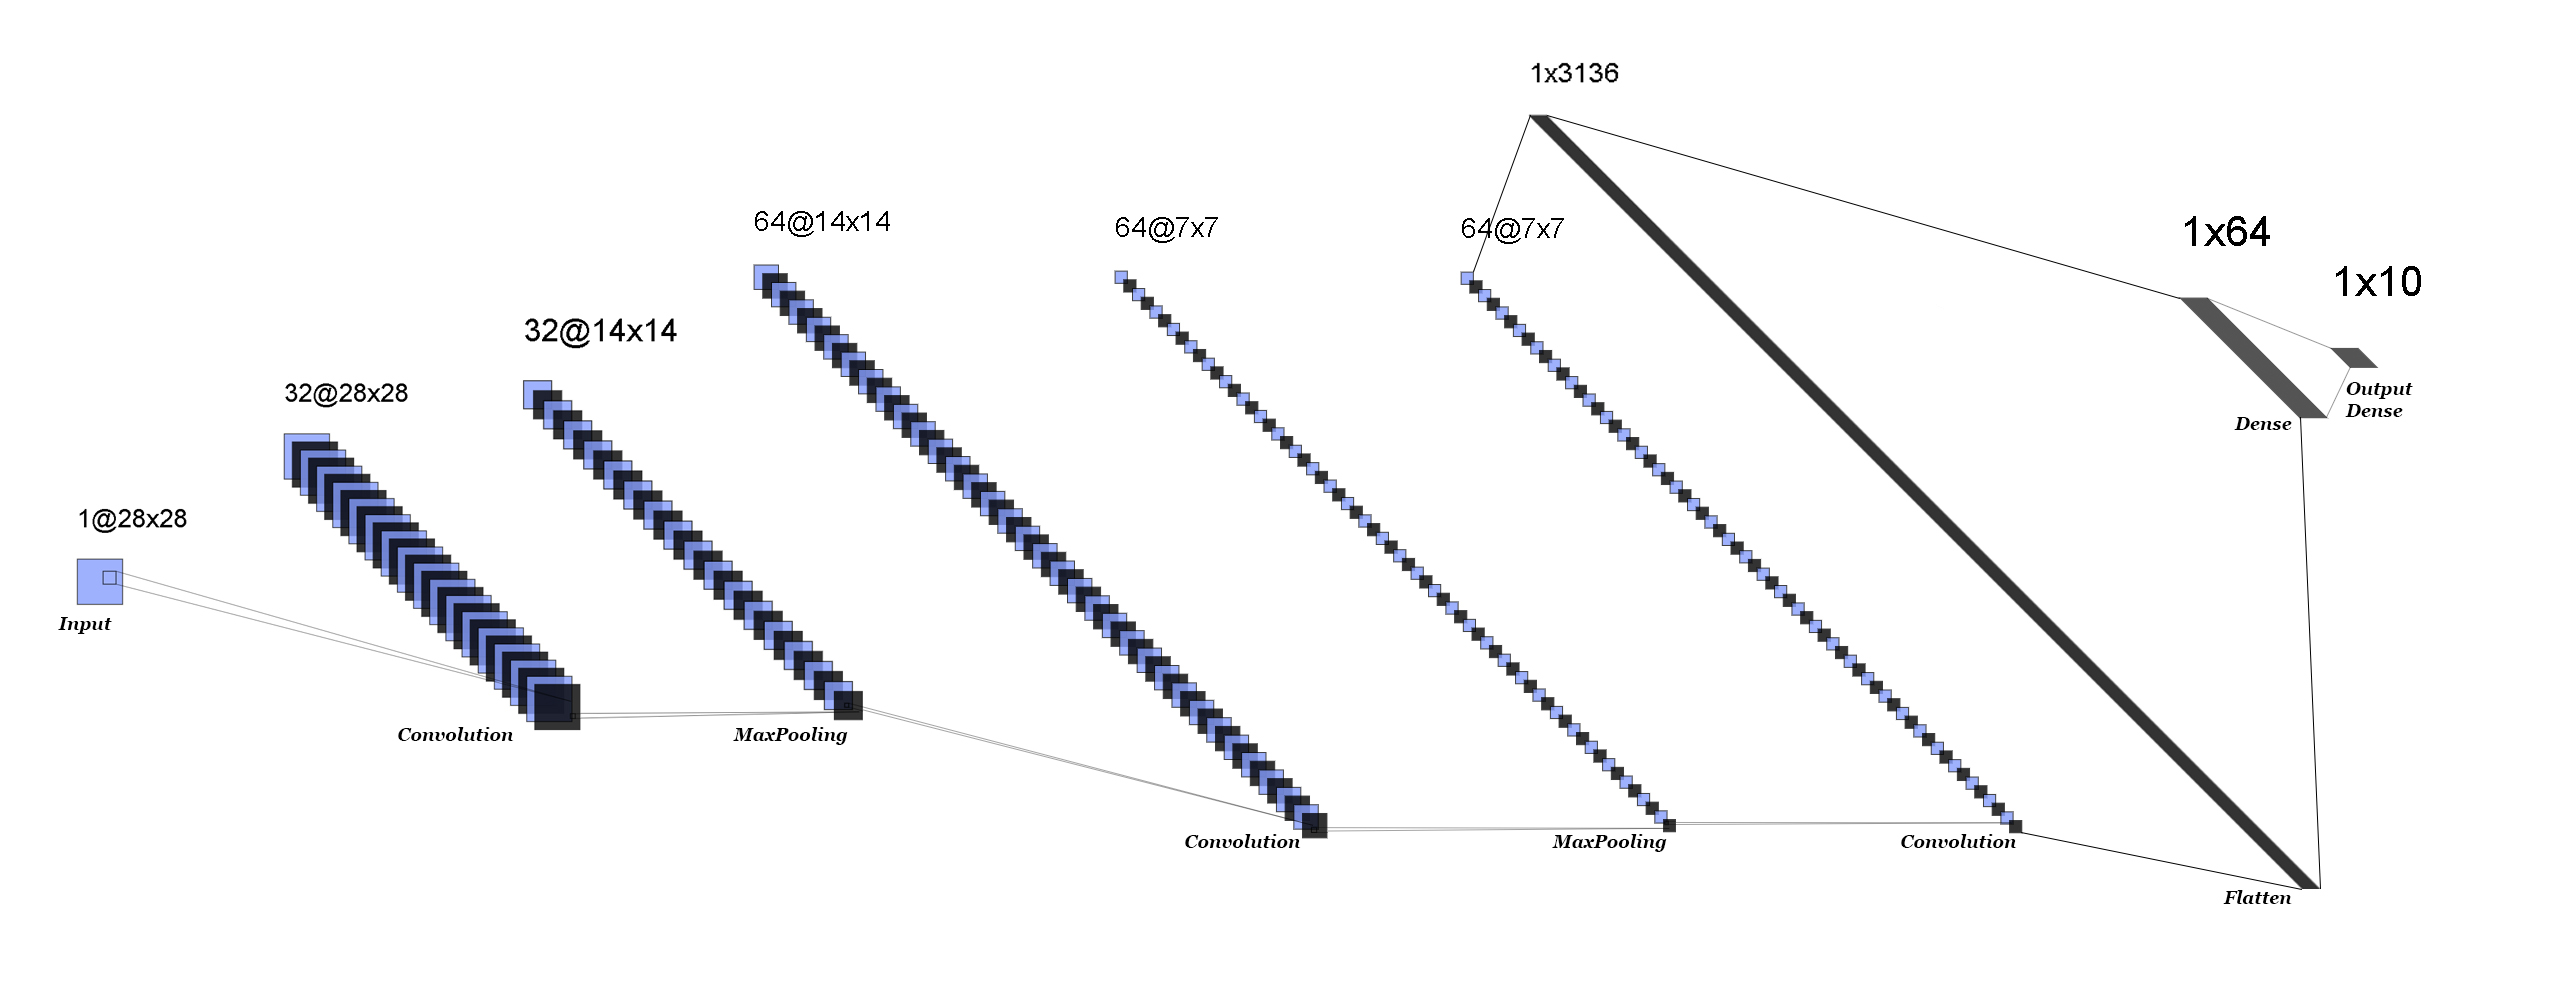

In [56]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Verifica se a acurácia de treinamento e validação atingiram 1.0 (100%)
        if logs.get('accuracy') >= 1.0 and logs.get('val_accuracy') >= 1.0:
            print("\nAcurácia de treinamento e validação atingiram 100%! Parando o treinamento.")
            self.model.stop_training = True

# Instanciar o callback
custom_early_stopping = CustomEarlyStopping()

# Configuração do otimizador com um learning rate específico
adam = Adam(learning_rate=0.001)

# Definir a arquitetura da CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1), input_shape=(28, 28, 1))) 
model.add(layers.MaxPooling2D((2, 2)))  # Pooling de 2x2 para reduzir a dimensionalidade
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))  
model.add(layers.MaxPooling2D((2, 2)))  # Pooling de 2x2 para reduzir a dimensionalidade
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))  

# Adicionar camadas densas com regularização L2
model.add(layers.Flatten()) # Transforma a matriz 2D em um vetor 1D de dimensão 7*7*64
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1))) # Camada densa com 64 neurônios
#model.add(layers.Dropout(0.9)) # Dropout de 90% para regularização
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.1)))# Camada de saída com 10 neurônios (um para cada classe)

# Compilar o modelo com o otimizador configurado
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_val, y_val)) # atualização dos pesos a cada 128 amostras

# Avaliar o modelo
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f'Val accuracy: {test_acc}, Train accuracy: {history.history["accuracy"][-1]}')

Epoch 1/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.8179 - loss: 1.9173 - val_accuracy: 0.9773 - val_loss: 0.4841
Epoch 2/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9829 - loss: 0.4026 - val_accuracy: 0.9837 - val_loss: 0.2615
Epoch 3/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9869 - loss: 0.2236 - val_accuracy: 0.9838 - val_loss: 0.1778
Epoch 4/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 79ms/step - accuracy: 0.9868 - loss: 0.1503 - val_accuracy: 0.9870 - val_loss: 0.1231
Epoch 5/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.9896 - loss: 0.1041 - val_accuracy: 0.9875 - val_loss: 0.0990
Epoch 6/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.9914 - loss: 0.0797 - val_accuracy: 0.9858 - val_loss: 0.0928
Epoch 7/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9915 - loss: 0.0698 - val_accuracy: 0.9890 - val_loss: 0.0746
Epoch 8/100
422/422 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9926 - loss: 0

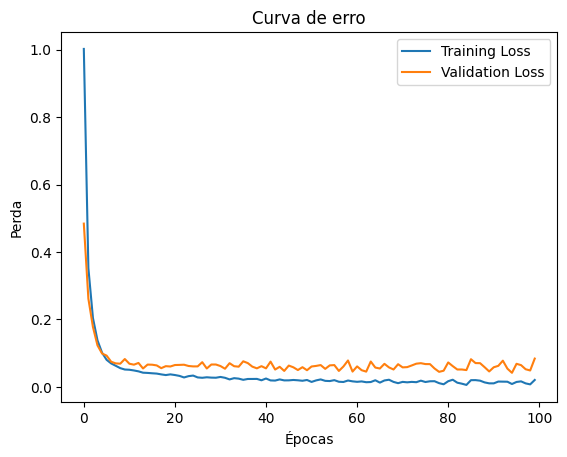

In [57]:
# Plota a curva de perda
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de erro')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


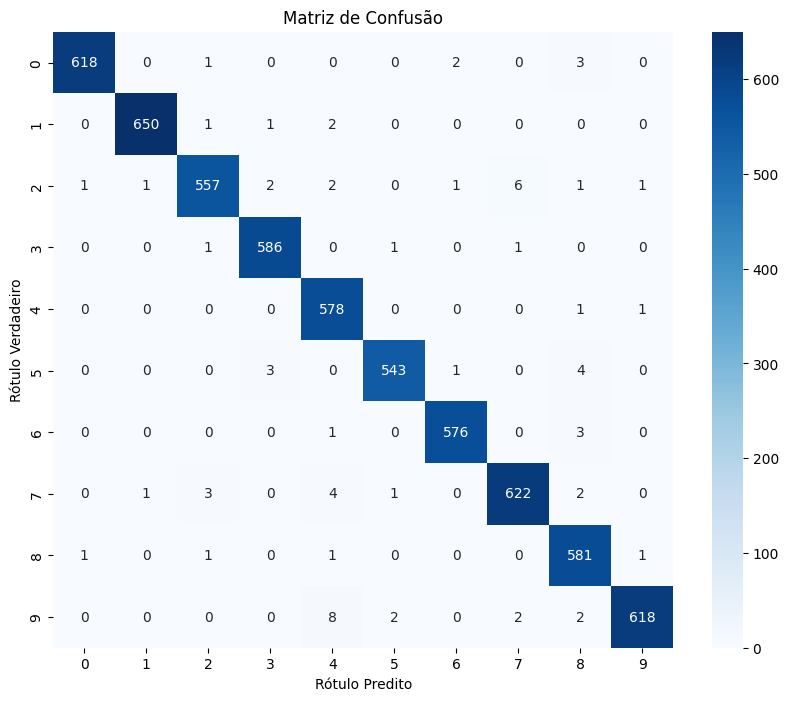

In [58]:
# Fazer previsões
predictions = model.predict(X_val)

# Converter previsões e rótulos de one-hot encoding para rótulos de classe
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Calcular a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

### Usando a rede neural perceptron de múltiplas camadas clássica,

### Tratamento dos dados

In [95]:
# Achatar as imagens e normalizar
X_train_flattened = X_train.reshape(X_train.shape[0], -1) / 255.0 # Normalizar os valores de pixel para o intervalo [0, 1]
X_val_flattened = X_val.reshape(X_val.shape[0], -1) / 255.0 # Normalizar os valores de pixel para o intervalo [0, 1]

In [98]:
X_train_flattened = X_train_flattened.T
y_train = y_train.T
X_val_flattened = X_val_flattened.T
y_val = y_val.T

In [115]:
# Definir dimensões das camadas
layer_dims = [X_train_flattened.shape[0], 128, y_train.shape[0]]  # Inclui a camada de entrada e a camada de saída

# Inicializar parâmetros
parameters = initialize_parameters_deep(layer_dims)

v, s = initialize_adam(parameters)

costs_train = []
accuracies_train = []
costs_val = []
accuracies_val = []

t = 0  # Inicializador para o Adam

lambd = 0.1
keep_prob = 0.5
learning_rate = 0.001

for i in range(4000):
    t += 1
    
    # Propagação para frente (com dropout aplicado no treinamento)
    AL, caches = L_model_forward(X_train_flattened, parameters, hidden_activation='relu', output_activation='softmax', keep_prob=keep_prob)
    
    # Propagação pra frente nos dados de validação (sem dropout)
    AL_val, _ = L_model_forward(X_val_flattened, parameters, hidden_activation='relu', output_activation='softmax')
    
    # Cálculo do custo (com regularização L2)
    cost = compute_cost(AL, y_train, parameters, lambd=lambd, problema='classificacao_multiclasse')
    costs_train.append(cost)
    
    cost_val = compute_cost(AL_val, y_val, parameters, lambd=lambd, problema='classificacao_multiclasse')
    costs_val.append(cost_val)
    
    # Cálculo da acurácia
    predictions = np.argmax(AL, axis=0)
    true_labels = np.argmax(y_train, axis=0)
    accuracy = np.mean(predictions == true_labels) * 100
    
    predictions_val = np.argmax(AL_val, axis=0)
    true_labels_val = np.argmax(y_val, axis=0)
    accuracy_val = np.mean(predictions_val == true_labels_val) * 100
    
    # Retropropagação e atualização dos parâmetros
    grads = L_model_backward(AL, y_train, caches, lambd=lambd, keep_prob=keep_prob, hidden_activation='relu', output_activation='softmax', problema='classificacao_multiclasse')
    parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)

    if i % 1 == 0:
        print(f"Iteração {i}: Treino Custo = {cost:.2f}, Treino Acurácia = {accuracy:.2f}%, Validação Custo = {cost_val:.2f}, Validação Acurácia = {accuracy_val:.2f}%")

    if accuracy >= 100 and accuracy_val >= 100:
        print(f"Acurácia de treinamento e validação atingiram 100%! Parando o treinamento.")
        break

Iteração 0: Treino Custo = 2.30, Treino Acurácia = 6.78%, Validação Custo = 2.30, Validação Acurácia = 6.83%
Iteração 1: Treino Custo = 2.30, Treino Acurácia = 35.74%, Validação Custo = 2.30, Validação Acurácia = 34.90%
Iteração 2: Treino Custo = 2.30, Treino Acurácia = 38.87%, Validação Custo = 2.30, Validação Acurácia = 37.85%
Iteração 3: Treino Custo = 2.30, Treino Acurácia = 44.10%, Validação Custo = 2.30, Validação Acurácia = 43.05%
Iteração 4: Treino Custo = 2.30, Treino Acurácia = 47.70%, Validação Custo = 2.30, Validação Acurácia = 46.42%
Iteração 5: Treino Custo = 2.29, Treino Acurácia = 49.12%, Validação Custo = 2.29, Validação Acurácia = 47.92%
Iteração 6: Treino Custo = 2.29, Treino Acurácia = 48.84%, Validação Custo = 2.29, Validação Acurácia = 47.98%
Iteração 7: Treino Custo = 2.28, Treino Acurácia = 48.71%, Validação Custo = 2.28, Validação Acurácia = 47.62%
Iteração 8: Treino Custo = 2.27, Treino Acurácia = 48.49%, Validação Custo = 2.27, Validação Acurácia = 47.32%
Ite

KeyboardInterrupt: 

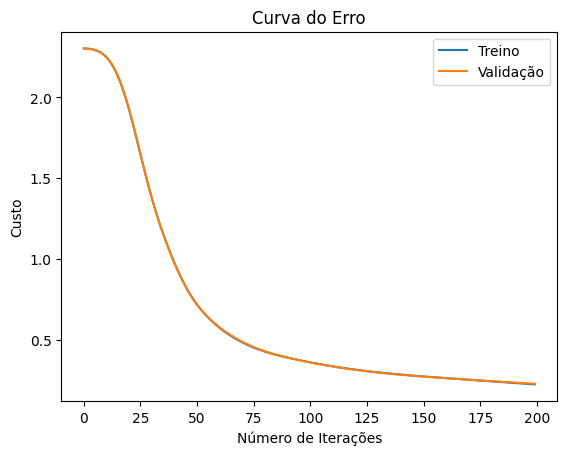

In [111]:
# plot do erro
plt.plot(range(len(costs_train)), costs_train, label='Treino')
plt.plot(range(len(costs_val)), costs_val, label='Validação')
plt.title('Curva do Erro')
plt.xlabel('Número de Iterações')
plt.ylabel('Custo')
plt.legend()
plt.show()

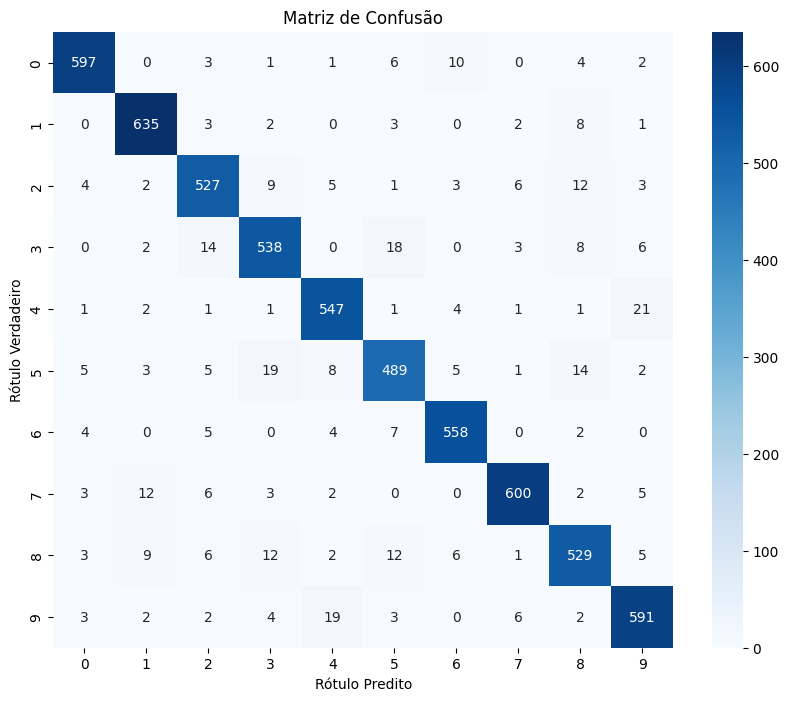

In [112]:
# Matriz de confusão
predictions_val_final = predictions_val.flatten()
y_val_final = true_labels_val

cm = confusion_matrix(y_val_final, predictions_val_final)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()

### Questão 3

In [143]:
def load_cifar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

def load_cifar10_test_batch(cifar10_dataset_folder_path):
    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
    return features, labels

cifar10_path = r"C:\Users\arthu\Downloads\cifar-10-python\cifar-10-batches-py"
x_train, y_train = [], []

for i in range(1, 6):
    features, labels = load_cifar10_batch(cifar10_path, i)
    x_train.extend(features)
    y_train.extend(labels)

x_train = np.array(x_train)
y_train = np.array(y_train)

# Carregando os dados de teste
x_test, y_test = load_cifar10_test_batch(cifar10_path)
y_test = np.array(y_test)

In [146]:
# Converte as etiquetas de treino e teste para one-hot encoding
# Número de classes para o CIFAR-10 é 10
num_classes = 10
y_train = convert_to_one_hot(y_train, num_classes)
y_test = convert_to_one_hot(y_test, num_classes)

In [151]:
class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Verifica se a acurácia de treinamento e validação atingiram 1.0 (100%)
        if logs.get('accuracy') >= 1.0 and logs.get('val_accuracy') >= 1.0:
            print("\nAcurácia de treinamento e validação atingiram 100%! Parando o treinamento.")
            self.model.stop_training = True

# Instanciar o callback
custom_early_stopping = CustomEarlyStopping()

# Configuração do otimizador com um learning rate específico
adam = Adam(learning_rate=0.001)

# Definir a arquitetura da CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1, 1), input_shape=(32, 32, 3))) 
model.add(layers.MaxPooling2D((2, 2)))  # Pooling de 2x2 para reduzir a dimensionalidade
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))  
model.add(layers.MaxPooling2D((2, 2)))  # Pooling de 2x2 para reduzir a dimensionalidade
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=(1, 1)))  

# Adicionar camadas densas com regularização L2
model.add(layers.Flatten()) # Transforma a matriz 2D em um vetor 1D de dimensão 7*7*64
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1))) # Camada densa com 64 neurônios
#model.add(layers.Dropout(0.9)) # Dropout de 90% para regularização
model.add(layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.1)))# Camada de saída com 10 neurônios (um para cada classe)

# Compilar o modelo com o otimizador configurado
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinar o modelo
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_data=(x_test, y_test)) # atualização dos pesos a cada 128 amostras

# Avaliar o modelo
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Val accuracy: {test_acc}, Train accuracy: {history.history["accuracy"][-1]}')

Epoch 1/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 37s 90ms/step - accuracy: 0.2773 - loss: 12.1116 - val_accuracy: 0.4794 - val_loss: 4.0051
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 98ms/step - accuracy: 0.5136 - loss: 3.4986 - val_accuracy: 0.5547 - val_loss: 2.4580
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 47s 120ms/step - accuracy: 0.5710 - loss: 2.2654 - val_accuracy: 0.5973 - val_loss: 1.8032
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 50s 128ms/step - accuracy: 0.6090 - loss: 1.6989 - val_accuracy: 0.6313 - val_loss: 1.4921
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 44s 112ms/step - accuracy: 0.6369 - loss: 1.4203 - val_accuracy: 0.6070 - val_loss: 1.4345
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 93ms/step - accuracy: 0.6517 - loss: 1.2749 - val_accuracy: 0.6656 - val_loss: 1.1990
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 42s 107ms/step - accuracy: 0.6779 - loss: 1.1570 - val_accuracy: 0.6721 - val_loss: 1.1552
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.6899 - l

KeyboardInterrupt: 

In [ ]:
# Plotar a curva de perda
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Curva de erro')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()
plt.show()

In [ ]:
# Plotar matriz de confusão
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Matriz de Confusão')
plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Rótulo Predito')
plt.show()